# Kik Data Science Challenge
The problem description states:
*   "We have made contact with multidimensional beings."
*   "Some of them are good some of them are evil. You need to tell them apart."

We were given a testing data set of ~480,000 aliens labeled as either good or evil. We were tasked with classifying a challenge set of ~480,000 unlabeled aliens.

This challenge was meant to emulate detecting spammers within the Kik userbase.

Our end result was a model that was able to correctly label the challenge set with 99.98% accuracy.

## Data Exploration

In [0]:
from sklearn import metrics, neighbors, cluster
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
data = pd.read_csv('training_file.csv', low_memory=False, index_col=0).dropna()

In [5]:
#Removes duplicate points from the data
nodup = data.drop_duplicates([str(i) for i in range(77)] + ["good"])
print(len(data), len(nodup))

470269 217680


In [0]:
features = data[[str(i) for i in range(77)]]
target = data["good"].astype(int)

nodup_features = nodup[[str(i) for i in range(77)]]
nodup_target = nodup["good"].astype(int)

Projecting the data into 2-D, we see it appears to be completely dense (similar results along any two axes)

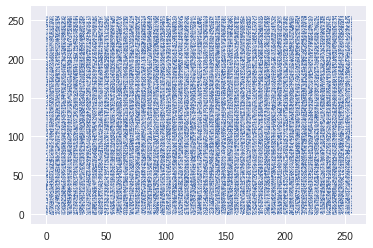

In [7]:
d = data
plt.scatter(d["5"], d["20"], s=0.01)

However, if we impose a seemingly loose constraint on each axis (only values <=240), we notice the data is actually quite sparse and only appears dense due to projecting a very high dimensional space into two dimensions

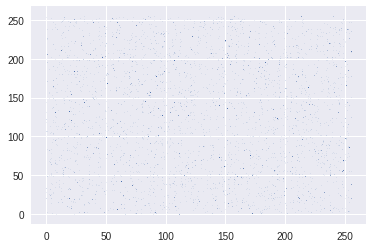

In [8]:
d = data[(data[[str(i) for i in range(77) if i not in [5, 20]]] <= 240).all(axis=1)]
plt.scatter(d["5"], d["20"], s=0.01)

Looking only at the "bad" guys we see some correlation

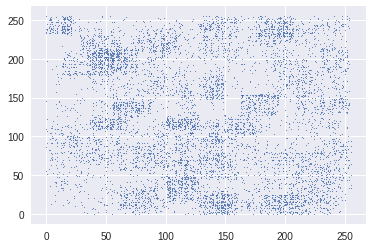

In [9]:
d = data[data["good"] == False]
plt.scatter(d["5"], d["20"], s=0.5)

Representing a third axis with colour shows us that the correlation exits in more than just the two dimensions. We see that the points appear to lie in some high dimensional cubes

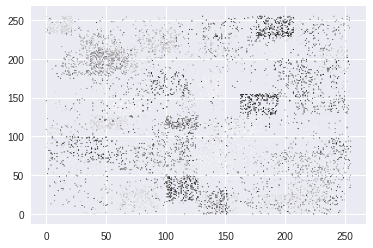

In [10]:
d = data[data["good"] == False]
plt.scatter(d["5"], d["20"], s=0.5, c=d["70"])

In [0]:
#Convert data to numerical matrix
vecs = nodup[[str(i) for i in range(77)]].as_matrix()

Given an arbitrary point (the 10th in this case), the following plot shows the histogram of the distances from that point to other points in the set. We see that, due to the high dimensionality, all the points are very far.

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.10000e+01, 5.88900e+03, 1.00516e+05, 1.06594e+05, 4.66900e+03]),
 array([   0.        ,  112.92820728,  225.85641456,  338.78462185,
         451.71282913,  564.64103641,  677.56924369,  790.49745098,
         903.42565826, 1016.35386554, 1129.28207282]),
 <a list of 10 Patch objects>)

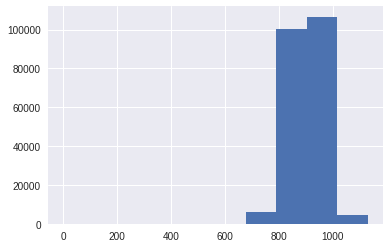

In [12]:
plt.hist(np.linalg.norm(vecs - np.tile(vecs[10], (vecs.shape[0], 1)), axis=1))

In [0]:
# Convert data for "bad" points into numerical matrix
d = nodup[nodup["good"]==False]
bvecs = d[[str(i) for i in range(77)]].as_matrix()

Doing a similar process as above among only bad points, we observe a similar phenomenon. However, we find a small population that is very close the chosen point (the point can be changed and similar behaviour will still be observed). This population of points forms a cluster, which is something that cannot be done with the vast majority of good points.

(array([  93.,   56.,    0.,    0.,    0.,    0.,  138., 4092., 3217.,
         125.]),
 array([   0.        ,  110.38944696,  220.77889392,  331.16834088,
         441.55778784,  551.9472348 ,  662.33668176,  772.72612872,
         883.11557568,  993.50502263, 1103.89446959]),
 <a list of 10 Patch objects>)

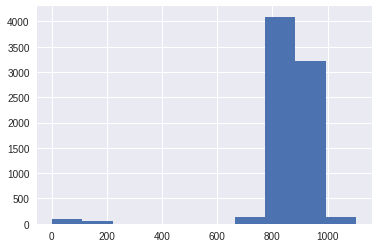

In [14]:
plt.hist(np.linalg.norm(bvecs - np.tile(bvecs[10], (bvecs.shape[0], 1)), axis=1))

By taking the sufficiently close points to a given point, we get a cluster for that point. Then, by the previous analysis, we can reasonably assume that this cluster will be rectangular and axis-aligned, so we find the bounding box for the cluster.

We notice that the side length is never greater than 32 and then the cluster is large enough, we will observe that most of the side lengths will achieve this upper bound. This implies that these clusters are generated through uniform randomly distributed numbers in each axis with a range of 32.

In [23]:
clust = bvecs[np.linalg.norm(bvecs - np.tile(bvecs[10], (bvecs.shape[0], 1)), axis=1) < 500]

print(len(clust))
print(clust.min(axis=0))
print(clust.max(axis=0))
print(1 + clust.max(axis=0) - clust.min(axis=0))

149
[ 57.  99. 128. 230.  98. 128. 175. 152. 128.   2. 225. 160. 233.  46.
 145. 213.  20. 184.  91. 167.  45.  11. 170.  70.  97.  43.   0.  87.
  27.  48. 201.  77. 159.  32. 107. 104. 128.  13. 131. 195. 212. 157.
   0.  80. 180.  35.   7. 207. 174. 216.  22.  57.  60.   0.   4. 128.
 184.  14. 184.  99. 167. 150. 187.   0.  50.  70.  69. 234. 168. 128.
   3. 128. 149.   0. 145. 154.  44.]
[ 88. 127. 154. 255. 127. 159. 206. 183. 144.  33. 255. 191. 255.  77.
 176. 244.  51. 215. 122. 198.  76.  42. 201. 101. 127.  74.  19. 118.
  58.  79. 232. 108. 190.  63. 127. 127. 150.  44. 162. 226. 243. 188.
  26. 111. 211.  66.  38. 238. 204. 247.  53.  87.  91.  21.  35. 148.
 215.  45. 215. 127. 198. 181. 218.  16.  81. 101. 100. 255. 199. 145.
  34. 157. 180.  22. 176. 185.  75.]
[32. 29. 27. 26. 30. 32. 32. 32. 17. 32. 31. 32. 23. 32. 32. 32. 32. 32.
 32. 32. 32. 32. 32. 32. 31. 32. 20. 32. 32. 32. 32. 32. 32. 32. 21. 24.
 23. 32. 32. 32. 32. 32. 27. 32. 32. 32. 32. 32. 31. 32. 32. 31. 3

## Training the Model

Given the previous analysis, we know that bad points are likely nearby to other points (which are also bad points), while good points are far from all or almost all points. Thus, a reasonable direction to take with the model is to measure the number of nearby points for each point then select based on that. However, due to the size of the dataset, this is computationally infeasible by brute force.

To simplify this process, we employ k-means clustering. This creates partitions of the data which tries to group together dense regions of the space. We also wanted each mean to roughly represent each cluster, so we chose 300 mean points (which is roughly the number of means that we have found via experimentation).

Now we have many clusters that are much smaller than the total dataset, so doing computations in these clusters is significantly easier. Within these clusters, if a point is near another point nearby, we consider it to be a potential bad point, but if the converse occurs it is almost definitely a good point. This drastically reduces the number of points that need to be considered as bad points.

To do a strict filtering for the bad points, we realize that the neighbours for a point are bad (bad points have many bad neighbours while good points have very few neighbours). This means that when we want to look for the nearby neighbours of a point, it suffices to only look at the potential bad points that were determined from before. Since this set is much smaller than the whole dataset, it is now computationally feasible and we simply brute force on the whole dataset by comparing only to these potential bad points. Anything that is found to have many nearby points (greater than 4) is classified as a bad point, otherwise it's classified as good.

In [0]:
# K-Means Clustering
try:
    centroids = pkl.load(open("k_means.pkl", 'rb'))[0]
except:
    c = cluster.k_means(features, n_clusters = 300)
    centroids = c[0]
    pkl.dump(c, open("k_means.pkl", 'wb'))

In [0]:
try:
    bad = pkl.load(open("bad.pkl", "rb"))
except:
    data = np.array(nodup_features)

    sofar = None
    # Iterate over chunks of the data due to memory constraints
    for subdata in np.array_split(data,100):
        # Find the distance between each centroid and the dataset (split data
        # into clusters based on centroids)
        val = np.argmin(np.linalg.norm(np.tile(np.expand_dims(subdata,1),(1,len(centroids),1)) - 
                                          np.tile(np.expand_dims(centroids,0),(len(subdata),1,1)),axis=2),axis=1)
        if sofar is None:
            sofar = val
        else:
            sofar = np.concatenate([sofar, val])
            
    clusters = [data[sofar==i] for i in range(len(centroids))]
    
    bad = None
    
    # Within each cluster, do a light filter to remove most good points
    for cluster in clusters:
        tree = neighbors.KDTree(cluster)
        val = cluster[np.array(tree.query_radius(cluster, r=250, count_only=True)) >= 2]

        if bad is None:
            bad = val
        else:
            bad = np.concatenate([bad,val], axis=0)
    
    pkl.dump(bad, open("bad.pkl", "wb"))

In [0]:
try:
    new_bad = pkl.load(open("new_bad.pkl", "wb"))
except:
    new_bad = None
    bt = neighbors.KDTree(bad)
    
    # Cleaning involves running a more strict filter, using all the remaining 
    # potential bad points
    def clean(X):
        return np.array(bt.query_radius(X, r=250, count_only=True)) > 4

    new_bad = bad[clean(bad)]
    pkl.dump(new_bad, open("new_bad.pkl", "wb"))

In [0]:
bads = new_bad.tolist()
output = []

# Export results
for i in range(len(features)):
    if features.loc[i].tolist() in bads:
        output.append(0)
    else:
        output.append(1)

## Testing the Results

In [0]:
np.savetxt("KIK_SOLUTIONS.txt", output)

In [49]:
print(metrics.classification_report(target, output))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99      8140
          1       1.00      1.00      1.00    462129

avg / total       1.00      1.00      1.00    470269

